[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AaronLin79/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/AaronLin79/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Positive: 12.31% (639 sentences)
Negative: 7.32% (380 sentences)
Neutral: 80.38% (4174 sentences)
Found 334 documents and 334 labels.
    00   01   02   10  100  10mb        11  1150   12  12v  ...  yesterday  \
0  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0  0.0  0.0  ...        0.0   
1  0.0  0.0  0.0  0.0  0.0   0.0  0.176936   0.0  0.0  0.0  ...        0.0   
2  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0  0.0  0.0  ...        0.0   
3  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0  0.0  0.0  ...        0.0   
4  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0  0.0  0.0  ...        0.0   

   yet  yield  you  youre  yourself  z525a  z6tv  zero  zipling  
0  0.0    0.0  0.0    0.0       0.0    0.0   0.0   0.0      0.0  
1  0.0    0.0  0.0    0.0       0.0    0.0   0.0   0.0      0.0  
2  0.0    0.0  0.0    0.0       0.0    0.0   0.0   0.0      0.0  
3  0.0    0.0  0.0    0.0       0.0    0.0   0.0   0.0      0.0  
4  0.0    0.0  0.0    0.0       0.0    0.0   0.0   0.0      0.0  



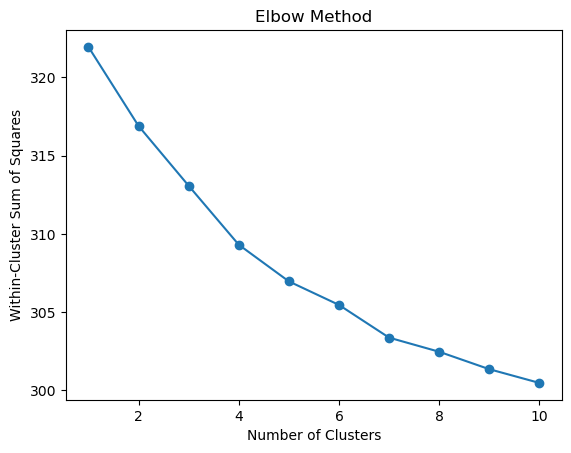

    00   01   02   10  100  10mb        11  1150   12  12v  ...  yet  yield  \
0  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0  0.0  0.0  ...  0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0   0.0  0.176936   0.0  0.0  0.0  ...  0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0  0.0  0.0  ...  0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0  0.0  0.0  ...  0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0  0.0  0.0  ...  0.0    0.0   

   you  youre  yourself  z525a  z6tv  zero  zipling  Cluster  
0  0.0    0.0       0.0    0.0   0.0   0.0      0.0        1  
1  0.0    0.0       0.0    0.0   0.0   0.0      0.0        1  
2  0.0    0.0       0.0    0.0   0.0   0.0      0.0        1  
3  0.0    0.0       0.0    0.0   0.0   0.0      0.0        1  
4  0.0    0.0       0.0    0.0   0.0   0.0      0.0        1  

[5 rows x 3465 columns]


In [1]:
# import libraries
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

nltk.download('stopwords')
nltk.download('punkt')


# filter reviews to only include the first 1000
def filter_reviews(input_file, filtered_reviews_file, max_reviews):
    with open(input_file, 'r') as infile, open(filtered_reviews_file, 'w') as outfile:
        review_count = 0
        current_review = {'product/title': None, 'review/text': None, 'review/score': None}
        
        for line in infile:
            # 'product/title' indicates a new review
            if line.startswith('product/title'):
                # if the current_review has a product title, review text, and review score, write all three to filtered_reviews_file
                if current_review['product/title'] and current_review['review/text'] and current_review['review/score']:
                    outfile.write(f"product/title: {current_review['product/title']}\n")
                    outfile.write(f"review/text: {current_review['review/text']}\n")
                    outfile.write(f"review/score: {current_review['review/score']}\n")
                    outfile.write('\n')
                    
                    review_count += 1
                    if review_count >= max_reviews:
                        break
                
            # reads in next review's product/title and sets initializes review text and review score to empty
                current_review['product/title'] = line.split(':', 1)[1].strip()
                current_review['review/text'] = None
                current_review['review/score'] = None
            # next read in that review's review/text or review/score
            elif line.startswith('review/text'):
                current_review['review/text'] = line.split(':', 1)[1].strip()
            elif line.startswith('review/score'):
                current_review['review/score'] = line.split(':', 1)[1].strip()
        
        # checks that very last review is output to filtered_reviews_file after loop 
        if review_count < max_reviews and current_review['product/title'] and current_review['review/text'] and current_review['review/score']:
            outfile.write(f"product/title: {current_review['product/title']}\n")
            outfile.write(f"review/text: {current_review['review/text']}\n")
            outfile.write(f"review/score: {current_review['review/score']}\n")
            outfile.write('\n')


# removes stopwords from the filtered reviews
def remove_stopwords(filtered_reviews_file, stopwords_file):
    with open(filtered_reviews_file, 'r') as infile:
        lines = infile.readlines()

    # sets up stopwords by accessing nltk library's English stopwords
    stop_words = set(stopwords.words('english'))
    
    # initializes empty list to store stopwords-processed lines
    filtered_lines = []
    
    # processes all review/text lines by filtering out stopwords
    for line in lines:
        if line.startswith('review/text:'):
            words = line.split()
            filtered_words = [word for word in words if word.lower() not in stop_words]
            # pieces together non-stop words back into string and stores in filtered_lines
            filtered_line = ' '.join(filtered_words) + '\n'
            filtered_lines.append(filtered_line)
        else:
            filtered_lines.append(line)

    with open(stopwords_file, 'w') as outfile:
        outfile.writelines(filtered_lines)


# clean reviews: remove punctuations (except periods) and convert to lowercase
def clean_reviews(stopwords_file, cleaned_reviews_file):
    with open(stopwords_file, 'r') as file:
        text = file.read()
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'([a-zA-Z])\.([a-zA-Z])', r'\1. \2', text)
        text = re.sub(r'([a-zA-Z])!([a-zA-Z])', r'\1! \2', text)
        text = re.sub(r"[^\w\s.!']", '', text)
    with open(cleaned_reviews_file, 'w') as file:
        file.write(text)


# create word dictionaries to define possible sentiment categories: 'positive', 'negative', 'neutral'
POSITIVE = 'positive'
NEGATIVE = 'negative'
NEUTRAL = 'neutral'

POSITIVE_WORDS = set([
    'amazing', 'awesome', 'best', 'brilliant', 'excellent', 'fantastic', 'great', 'impressive', 'perfect', 'wonderful', 'benefit', 
    'delight', 'excellence', 'joy', 'love', 'quality', 'satisfaction', 'value', 'adore', 'appreciate', 'enjoy', 'recommend', 
    'satisfy', 'surprise', 'absolutely', 'clearly', 'definitely', 'extremely', 'highly', 'perfectly', 'positively'
])

NEGATIVE_WORDS = set([
    'awful', 'bad', 'cheap', 'disappointing', 'horrible', 'poor', 'terrible', 'unacceptable', 'unsatisfactory', 'useless', 'complaint', 
    'disaster', 'flaw', 'issue', 'junk', 'problem', 'waste', 'complain', 'dislike', 'hate', 'refund', 'regret', 'return', 'barely', 
    'extremely', 'horribly', 'never', 'poorly', 'sadly', 'unfortunately'
])

# examines the number of words from a review that appear in previously defined 'POSITIVE_WORDS' and 'NEGATIVE_WORDS' lists
def categorize_sentence(sentence):
    words = sentence.lower().split()
    word_counts = Counter(words)
    
    # sum the counts of positive and negative words then compare to determine overall sentiment of each review
    positive_count = sum(word_counts[word] for word in POSITIVE_WORDS)
    negative_count = sum(word_counts[word] for word in NEGATIVE_WORDS)
    if positive_count > negative_count:
        return POSITIVE
    elif negative_count > positive_count:
        return NEGATIVE
    else:
        return NEUTRAL

# calculate positive, negative, neutral sentiment percentages (Credit to code in Text Mining slides)
def parse_reviews(cleaned_reviews_file):
    with open(cleaned_reviews_file, 'r') as file:
        text = file.read()
    
    # uses nltk's sent_tokenize() to obtain the different reviews
    sentences = nltk.sent_tokenize(text)
    # applies categorize_sentence() to each review to determine its overall sentiment
    categorized_sentences = [categorize_sentence(sentence) for sentence in sentences]
    
    # counts the number of reviews that fall into either 'positive', 'negative', or 'neutral'
    positive_count = sum(1 for category in categorized_sentences if category == POSITIVE)
    negative_count = sum(1 for category in categorized_sentences if category == NEGATIVE)
    neutral_count = sum(1 for category in categorized_sentences if category == NEUTRAL)
    
    # counts total number of reviews whose sentiments were analyzed
    total_sentences = len(categorized_sentences)
    
    # calculates percentages of positive/negative/neutral reviews
    # sets percentages to 0 if there are 0 reviews to categorize
    if total_sentences > 0:
        positive_percent = (positive_count / total_sentences) * 100
        negative_percent = (negative_count / total_sentences) * 100
        neutral_percent = (neutral_count / total_sentences) * 100
    else:
        positive_percent = negative_percent = neutral_percent = 0

    # displays percentages of reviews in each sentiment category
    print(f"Positive: {positive_percent:.2f}% ({positive_count} sentences)")
    print(f"Negative: {negative_percent:.2f}% ({negative_count} sentences)")
    print(f"Neutral: {neutral_percent:.2f}% ({neutral_count} sentences)")


# tokenizes reviews to use in Bag-of-Words
def tokenize_reviews(cleaned_reviews_file):
    with open(cleaned_reviews_file, 'r') as file:
        lines = file.readlines()

    reviews = [
        # only keeps letters, digits, and whitespace
        # then removes leading/trailing whitespace as well as 'review/text:' from the actual review text
        # uses nltk library's word_tokenize function to tokenize the now cleaned reviews
        nltk.word_tokenize(re.sub(r'[^a-zA-Z0-9\s]', '', line[len('reviewtext'):].strip()))
        for line in lines if line.startswith('reviewtext')
    ]
    
    return reviews


# extracts unique words from the tokenized reviews
def get_unique_words(reviews):
    # set() removes duplicates since sets don't allow duplicate elements
    unique_words = list(set(word for review in reviews for word in review))
    
    return unique_words


# save Bag-of-Words representation into a file
def bag_of_words(reviews, unique_words, output_file):
    # initialize empty dictionary to store Bag-of-Words for each document/review
    bow = {}
    
    # map seach unique word to an index within vector
    word_to_index = {word: index for index, word in enumerate(unique_words)}

    
    with open(output_file, 'w') as file:
        for i, review in enumerate(reviews):
            doc_vector = [0] * len(unique_words)

            for word in review:
                if word in word_to_index:
                    # if word is in the word_to_index dictionary, increment its index and move to next word 
                    word_index = word_to_index[word]
                    doc_vector[word_index] += 1
            
            bow[f"Document {i+1}"] = doc_vector
            file.write(f"Document {i+1}: {doc_vector}\n")

    return bow


# TF-IDF
def tfidf(input_file):
    # initializes empty lists to store review texts and review scores
    documents = []
    labels = []
    
    # parses through each review and its corresponding product title, review text, and review score
    with open(input_file, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 3): 
            if lines[i].startswith('producttitle'):
                
                # extract each review's review text and review score
                review_text = lines[i+1][len('reviewtext '):].strip()
                documents.append(review_text)
                review_score = float(lines[i+2][len('reviewscore '):].strip())
                labels.append(review_score)
    
    if not documents:
        raise ValueError("Error: Document not found!")

    # prints number of review texts/documents and review scores/labels found
    print(f"Found {len(documents)} documents and {len(labels)} labels.")

    # applies the TfidfVectorizer() to each review text/document
    # transforms computations into a TF-IDF matrix
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_data = tfidf_matrix.toarray()

    # transforms TF-IDF findings into a dataframe where column headers are the unique words
    tfidf_df = pd.DataFrame(tfidf_data, columns=feature_names)

    return tfidf_df, labels


# K-Nearest Neighbors (Supervised Learning Technique)
def knn_classification(tfidf_df, labels):
    # Convert the labels to binary (positive: 1, negative: 0)
    binary_labels = [1 if score > 3.0 else 0 for score in labels]

    # Split data into training and testing sets (80/20 Split w/implemented randomization)
    X_train, X_test, y_train, y_test = train_test_split(tfidf_df, binary_labels, test_size=0.2, random_state=99)

    # Decided on optimal k using sqrt(n)/2 = sqrt(1000)/2
    knn = KNeighborsClassifier(n_neighbors=16)

    # Train and make predictions
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) # Compute accuracy comparing predicted to actual
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")


# Elbow Method (trying to find optimal number of clusters)
def elbow_method(tfidf_df, max_clusters=10):
    wcss = []
    for i in range(1, max_clusters + 1): # Iterates through clusters to calculate sum of squares
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=99)
        kmeans.fit(tfidf_df)
        wcss.append(kmeans.inertia_)
    
    # Visualize plot
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares')
    plt.show()


# K-Means Clustering (Unsupervised Learning Technique)
def kmeans_clustering(tfidf_df, n_clusters=4):
    # Initialize K-Means with explicit n_init
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=99)
    kmeans.fit(tfidf_df)

    # Cluster Assignments
    cluster_labels = kmeans.labels_

    # DataFrame
    clustered_df = tfidf_df.copy()
    clustered_df['Cluster'] = cluster_labels

    print(clustered_df.head())

    return clustered_df, cluster_labels


# I/O files
input_file = 'Cell_Phones_&_Accessories.txt'
filtered_reviews_file = 'filtered_reviews.txt'
stopwords_file = 'reviews_no_stopwords.txt'
cleaned_reviews_file = 'cleaned_reviews.txt'
bag_of_words_file = 'bag_of_words.txt'

max_reviews = 1000 # Limit massive dataset to 1000 reviews for simplicity

filter_reviews(input_file, filtered_reviews_file, max_reviews)
remove_stopwords(filtered_reviews_file, stopwords_file)
clean_reviews(stopwords_file, cleaned_reviews_file)
reviews = tokenize_reviews(cleaned_reviews_file)
unique_words = get_unique_words(reviews)
bow_representation = bag_of_words(reviews, unique_words, bag_of_words_file)

parse_reviews(cleaned_reviews_file)

# TF-IDF
tfidf_df, labels = tfidf(cleaned_reviews_file)
# Save TF-IDF dataframe to a .csv file to check
tfidf_df.to_csv('tfidf_output.csv', index=False)
print(tfidf_df.head())

# K-Nearest Neighbors
knn_classification(tfidf_df, labels)

# Elbow Method
elbow_method(tfidf_df)

# K-Means Clustering
clustered_df, cluster_labels = kmeans_clustering(tfidf_df)

# Put K-Means Clustering results into a .csv file to check
clustered_df.to_csv('kmeans_output.csv', index=False)

# ANALYSIS

Sentiments:<br>
From our results, we can see that the majority of the reviews appear to be neutral, which may be a sign that our model may be inaccurate, given that most people tend to leave reviews when they have stronger positive/negative feelings towards products. However, from the other sentiments, we can see that there are marginally more positive reviews than negative ones. Another issue that our model may have experienced is an inaccurate representation of the sentiments given our dictionaries. Since we created dictionaries for positive and negative keywords, we may have failed to include a comprehensive set of vocabularies. For example, we may have missed certain words that were common throughout reviews, but may indicate a specific sentiment. Lastly, a problem we may have incurred was the misclassification of unique words. Throughout our data cleaning process, we tried our best to clean out the data, but due to user error, some words may have been mistyped, and resulted in them being classified as unique words rather than being counted as a duplicate or stop word.

Bag-of-Words/TF-IDF:
Set bag-of-words vector to length of unique words throughout all 1000 reviews (Length of 3464). Created an empty dictionary to store the Bag-of-Words representation for each document. For each word in the review, if the word exists in the word-to-index mapping, increment the corresponding index in the document vector. Open the input file and read its contents. Extract review text and review scores. Fit and transform the review texts to obtain the TF-IDF matrix. Retrieve feature names from the TF-IDF vectorizer. Convert the TF-IDF matrix to a dense array and create a DataFrame using the feature names as column headers.

K-Nearest Neighbors:<br>
Our model performs better at identifying positive reviews (Class 1) with a higher recall of 0.93 in comparison to negative reviews (Class 0) with a lower recall of 0.30. This indicates that the model is more effective at detecting positive sentiments than negative ones. Our overall accuracy is 67.16%, which is decent. For our F1-score, we are aiming for a value of 1, but instead received values of 0.42 and 0.77, which are not too poor. The imbalance in class support could be impacting the performance, since support is the number of actual occurrences of the classes, we can see that there is a disproportionate amount of positive reviews (greater amount) in comparison to negative reviews (lesser amount).

Elbow Method:<br>
In order to determine the optimal number of clusters for K-Means Clustering, we created a function and utilized the elbow method. We coded it to calculate the sum of squares within clusters (given a range of potential cluster counts, which we set as 10) and plot a visual based off of the results. From our visual, we can see that the greatest difference, or the "elbow", appears to be around 4, 5, or 6 clusters. We ultimately decided to go with 4 clusters.

K-Means Clustering:<br>
Looking at the output, the dataframe columns represent terms from our TF-IDF matrix. For example, columns like "00", "01", and "10mb" are terms (words) present in the reviews. The values in these columns are the TF-IDF scores, indicating the importance of each term in the corresponding review. For instance, in the first review (0), the TF-IDF score for the term 11 is 0.000000, indicating that the term has little to no importance in this review. The last column, "Cluster", indicates the cluster label assigned to each review by the K-Means algorithm. In the output, the first few documents all belong to Cluster 1. This tells us that these documents share similar characteristics based on their TF-IDF values and are therefore grouped together by the algorithm.

CONTRIBUTIONS:

Aaron Lin (Second-year undergraduate):<br>
Cleaned data. Implemented K-NN, Elbow Method, and K-Means Clustering. Analyzed results.

Banff Jiang (Second-year undergraduate):<br>
Cleaned data. Implemented Bag-of-Words, TF-IDF, K-NN.

Cathy Wu (Second-year undergraduate):<br>
Cleaned data. Implemented Bag-of-Words, TF-IDF, sentiments (tokenizing and unique words vector), and K-Means Clustering. Analyzed results.

Darren Banh (Second-year undergraduate):<br>
Cleaned data. Implemented sentiments (tokenizing and unique words vector). Analyzed results.